<center><img src="trainers.jpg" alt="Trainers in a store" width=550></center>
 (`Source: https://www.statista.com/statistics/254489/total-revenue-of-the-global-sports-apparel-market/`)


### The data:
`brands.csv`

| Columns | Description |
|---------|-------------|
| `product_id` | Unique product identifier |
| `brand` | Brand of the product | 

`finance.csv`

| Columns | Description |
|---------|-------------|
| `product_id` | Unique product identifier |
| `listing_price` | Original price of the product | 
| `sale_price` | Discounted price of the product |
| `discount` | Discount off the listing price, as a decimal | 
| `revenue` | Revenue generated by the product |

`info.csv`

| Columns | Description |
|---------|-------------|
| `product_name` | Name of the product | 
| `product_id` | Unique product identifier |
| `description` | Description of the product |

`reviews.csv`

| Columns | Description |
|---------|-------------|
| `product_id` | Unique product identifier |
| `rating` | Average product rating | 
| `reviews` | Number of reviews for the product |

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Loading the data
brands = pd.read_csv("brands.csv") 
finance = pd.read_csv("finance.csv")
info = pd.read_csv("info.csv")
reviews = pd.read_csv("reviews.csv")

In [2]:
#Merge all datasets 
df = (
    finance
      .merge(brands[['product_id','brand']], on='product_id', how='left')
      .merge(info[['product_id','product_name','description']], on='product_id', how='left')
      .merge(reviews[['product_id','rating','reviews']], on='product_id', how='left')
)

# **Sales performance of Adidas and Nike products**

In [3]:
## Filter to only products from Adiads & Nike
df = df[df['brand'].isin(['Adidas','Nike'])]
df = df.dropna()

In [4]:
# Create quartile labels
quartile_labels = ["Budget", "Average", "Expensive", "Elite"]

# Cut listing_price into 4 quartiles and label them
df["price_label"] = pd.qcut(df["listing_price"], q=4, labels=quartile_labels)

df.head()

,product_id,listing_price,sale_price,discount,revenue,brand,product_name,description,rating,reviews,price_label
1,G27341,75.99,37.99,0.5,1641.17,Adidas,Women's adidas Originals Sleek Shoes,"A modern take on adidas sport heritage, tailor...",3.3,24.0,Expensive
2,CM0081,9.99,5.99,0.4,398.93,Adidas,Women's adidas Swim Puka Slippers,These adidas Puka slippers for women's come wi...,2.6,37.0,Budget
3,B44832,69.99,34.99,0.5,2204.37,Adidas,Women's adidas Sport Inspired Questar Ride Shoes,"Inspired by modern tech runners, these women's...",4.1,35.0,Expensive
4,D98205,79.99,39.99,0.5,5182.70,Adidas,Women's adidas Originals Taekwondo Shoes,This design is inspired by vintage Taekwondo s...,3.5,72.0,Expensive
5,B75586,47.99,19.20,0.6,1555.20,Adidas,Women's adidas Sport Inspired Duramo Lite 2.0 ...,Refine your interval training in these women's...,1.0,45.0,Average


In [5]:
_, bins = pd.qcut(df["listing_price"], q=4, retbins=True)
print("Quartile boundaries:", bins)

Quartile boundaries: [  0.    45.99  59.99  89.99 299.99]


In [6]:
#Group by brand and price_quartile
final_result = (df.groupby(['brand', 'price_label']).agg(num_products=('product_id', 'count'),
        mean_revenue=('revenue', 'mean')).reset_index())
final_result['mean_revenue'] = final_result['mean_revenue'].round(2)

final_result

,brand,price_label,num_products,mean_revenue
0,Adidas,Budget,574,2015.68
1,Adidas,Average,655,3035.30
2,Adidas,Expensive,759,4621.56
3,Adidas,Elite,587,8302.78
4,Nike,Budget,357,1596.33
5,Nike,Average,8,675.59
6,Nike,Expensive,47,500.56
7,Nike,Elite,130,1367.45


In [7]:
quartile_order = ["Budget", "Average", "Expensive", "Elite"]
final_result['price_label'] = pd.Categorical(final_result['price_label'], categories=quartile_order, ordered=True)
adidas_vs_nike = final_result.sort_values(['brand', 'price_label'])

adidas_vs_nike

,brand,price_label,num_products,mean_revenue
0,Adidas,Budget,574,2015.68
1,Adidas,Average,655,3035.30
2,Adidas,Expensive,759,4621.56
3,Adidas,Elite,587,8302.78
4,Nike,Budget,357,1596.33
5,Nike,Average,8,675.59
6,Nike,Expensive,47,500.56
7,Nike,Elite,130,1367.45


# Relationship Between Product Information and Reviews

In [8]:
# Find the length of each product description in words
df['description_length'] = info['description'].str.len()

# Get max word count
max_words = df['description_length'].max()

# Create limits and labels
bins   = [0, 100, 200, 300, 400, 500, 600, 700]
labels = [str(x) for x in bins[1:]]

# Bin the description lengths
df['description_length'] = pd.cut(
    df['description_length'],
    bins=bins,
    labels=labels,
    include_lowest=True,  
    right=True
)

description_lengths = df.groupby("description_length", as_index=False).agg(
    mean_rating=("rating", "mean"), 
    total_reviews=("reviews", "sum")
).round(2)

description_lengths.head()

,description_length,mean_rating,total_reviews
0,100,2.26,36.0
1,200,3.19,17719.0
2,300,3.28,76115.0
3,400,3.29,28994.0
4,500,3.35,4984.0


Price Quartile vs Mean Revenue

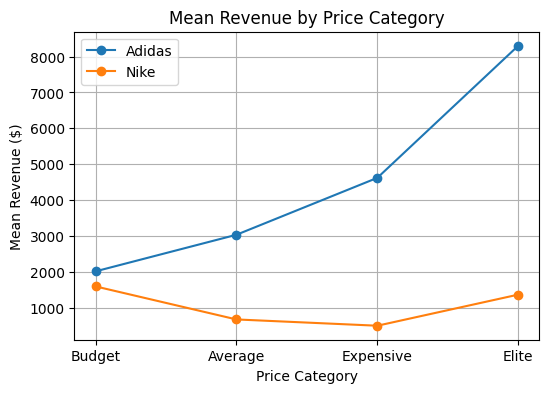

In [9]:
fig, ax = plt.subplots(figsize=(6,4))
for brand in final_result['brand'].unique():
    brand_data = final_result[final_result['brand'] == brand]
    ax.plot(brand_data['price_label'], brand_data['mean_revenue'], marker='o', label=brand)

ax.set_title('Mean Revenue by Price Category')
ax.set_ylabel('Mean Revenue ($)')
ax.set_xlabel('Price Category')
ax.legend()
ax.grid(True)

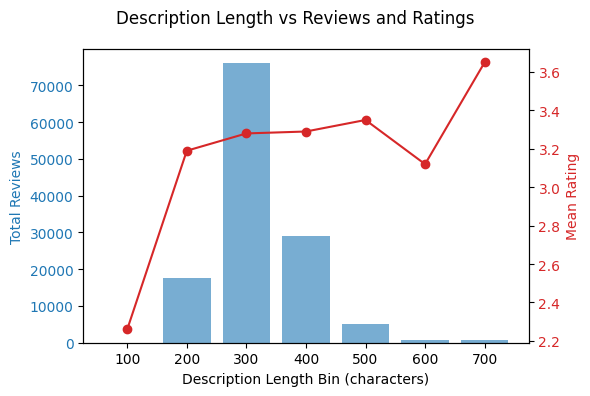

In [10]:
fig2, ax1 = plt.subplots(figsize=(6,4))

color = 'tab:blue'
ax1.set_xlabel('Description Length Bin (characters)')
ax1.set_ylabel('Total Reviews', color=color)
ax1.bar(description_lengths['description_length'], description_lengths['total_reviews'], 
        color=color, alpha=0.6, label='Total Reviews')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean Rating', color=color)
ax2.plot(description_lengths['description_length'], description_lengths['mean_rating'], 
         color=color, marker='o', label='Mean Rating')
ax2.tick_params(axis='y', labelcolor=color)

fig2.suptitle('Description Length vs Reviews and Ratings')
fig2.tight_layout()

plt.show()